**References:**

https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb

https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3

https://arxiv.org/abs/1511.06434

**Deep Convolution Generative Adversarial Network**

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.datasets.mnist import load_data
from skimage.transform import resize
import tensorflow as tf 
from tensorflow.keras.callbacks import TensorBoard
from os import path
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Step 1 : Load CIFAR Dataset

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Step 2: Per-process dataset

In [0]:
classes = len(np.unique(y_train))

Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

Step 3: Define generator network architecture

In [4]:
latent_dim = 100
init = initializers.RandomNormal(stddev=0.02)

generator = Sequential()

generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init, activation = 'relu'))
generator.add(Reshape((2,2,512)))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation = 'relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation = 'relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation = 'relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))

Step 4: Define discriminator network architecture

In [5]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# # Conv 3: 
discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

print(discriminator.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)        

Step 5: Define the grid output generation method

In [0]:
from matplotlib import pyplot as plt
def plot_data(x,ax):
    ax.imshow((x+1)/2, cmap='gray') # to rescale from -1,1 to 0,

def plot_images(x,batch_size=100):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        plot_data(x[i], ax)

fol = '/content/drive/My Drive/Colab Notebooks/DCGAN_final_1'

def plotGeneratedImages(epoch, examples=64, dim=(1, 1), figsize=(2, 2)):
    import os
    n_classes = 10
    z = np.random.normal(loc=0, scale=1, size=(64, latent_dim))
    X_fake = generator.predict_on_batch(z)
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(examples):
        ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
        plot_data(X_fake[i], ax)
    
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:05d}.png'.format(epoch))
    plt.close()

Step 6: Compling discriminator and GAN

Step 7: Define helper methods for calculating FID between two input distributions 

In [0]:
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
      new_image = resize(image, new_shape, 0)
      images_list.append(new_image)
    return asarray(images_list)

def calculate_actications(images1, images2,size):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images1 = images1.reshape((size,32,32,3))
    images2 = images2.reshape((size,32,32,3))
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    return act1, act2

def calculate_fid_from_activations(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
      covmean = covmean.real
    return ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)

step 8: Tensorboard visualizations

In [0]:
log_dir = '/content/drive/My Drive/Colab Notebooks/DCGAN_final_1'

tensorboard_d = TensorBoard(
  log_dir=log_dir,
  histogram_freq=0,
  batch_size=10,
  write_graph=True,
  write_grads=True
)
tensorboard_d.set_model(discriminator)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Step 9: Saving the best model

In [11]:
path_dir = "/content/drive/My Drive/Colab Notebooks/DCGAN_final_1"
disc_path = path_dir + "/disc.ckpt"
gen_path = path_dir + "/gen.ckpt"
gan_path = path_dir + "/gan.ckpt"

if path.exists(gen_path):
  # generator.compile(Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
  generator = load_model(gen_path)
else:
  generator.compile(Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

if path.exists(disc_path):
  # discriminator.compile(Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
  discriminator = load_model(disc_path)
else:
  discriminator.compile(Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

def save_model():
  discriminator.trainable = False
  d_g.save(gan_path)
  discriminator.trainable = True
  generator.save(gen_path)
  discriminator.save(disc_path)  

# discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Step 10: Training the GAN

In [12]:
epochs = 128
batch_size = 32
smooth = 0.1
current_fid = 100000
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
fid_total = []
d_loss = []
g_loss = []
act_fake_total = []
act_real_total = []
# iterations = 100000
for i in range(epochs):
  for j in range(len(X_train) // batch_size):
    discriminator.trainable = True
    X_batch = X_train[j*batch_size:(j+1)*batch_size]
    d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
    z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
    X_fake = generator.predict_on_batch(z)
    d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
    d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
    discriminator.trainable = False
    g_loss_batch = d_g.train_on_batch(x=z, y=real)
    
    tensorboard_d.on_epoch_end(i, {"D_real_loss":d_loss_real[0] ,"D_fake_loss":d_loss_fake[0],"GAN_loss":g_loss_batch[0]})
    
  if (i%10==0):
    z = np.random.normal(loc=0, scale=1, size=(1562, latent_dim))
    X_fake = generator.predict_on_batch(z)
    act_fake, act_real = calculate_actications(X_fake, X_test[:len(X_fake)], len(X_fake))
    fid = calculate_fid_from_activations(act_fake, act_real)
    if fid < current_fid:
      current_fid = fid
      save_model()
    fid_total.append(fid)
    print('FID: %.3f' % fid)
    plotGeneratedImages(i)

  d_loss.append(d_loss_batch)
  g_loss.append(g_loss_batch[0])
  print('Epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (i + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')






87916544/87910968 [==============================] - 1s 0us/step
FID: 145.679
Epoch = 1/128, d_loss=0.488, g_loss=3.913                                                                                                     
Epoch = 2/128, d_loss=0.578, g_loss=3.623                                                                                                     
Epoch = 3/128, d_loss=0.825, g_loss=2.735                                                                                                     
Epoch = 4/128, d_loss=0.409, g_loss=2.848                                                                                                     
Epoch = 5/128, d_loss=0.378, g_loss=2.870                                                                                                     
Epoch = 6/128, d_loss=0.510, g_loss=2.855                                                                                                     
Epoch = 7/128, d_loss=0.890, g_loss=2.072                   

In [35]:
tensorboard_d.on_train_end(None)
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/DCGAN_final_1/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 5133), started 0:25:44 ago. (Use '!kill 5133' to kill it.)

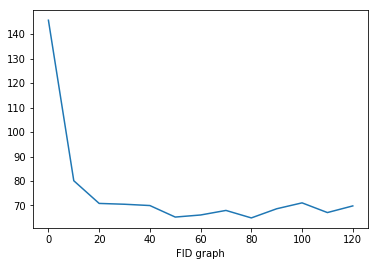

In [33]:
epochs = [(i*10) for i in range(13)]
# print(fid_total)
plt.plot(epochs, fid_total)
plt.xlabel("FID graph")
plt.show()

Step 11: Loading Best generator

FID for the generated 64 images = 78.08728123877174


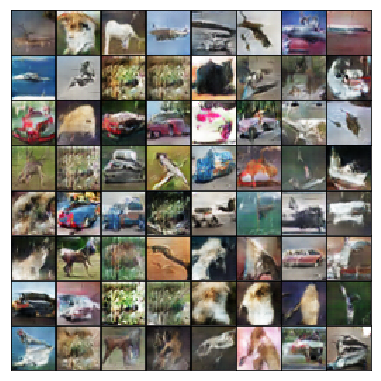

In [34]:
# from keras.models import Sequential, Model,load_model
# from matplotlib import pyplot as plt
# import os
# import numpy as np
# from keras.utils import np_utils
# from keras.datasets import cifar10
# from keras import backend as K
# from keras.applications.inception_v3 import InceptionV3
# from skimage.transform import resize
# from numpy import asarray
# from numpy import cov
# from numpy import trace
# from numpy import iscomplexobj


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.datasets.mnist import load_data
from skimage.transform import resize
import tensorflow as tf 
from tensorflow.keras.callbacks import TensorBoard
from os import path
import warnings
warnings.filterwarnings('ignore')

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
      new_image = resize(image, new_shape, 0)
      images_list.append(new_image)
    return asarray(images_list)

def plot_data(x,ax):
    ax.imshow((x+1)/2, cmap='gray') # to rescale from -1,1 to 0,

def calculate_actications(images1, images2,size):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images1 = images1.reshape((size,32,32,3))
    images2 = images2.reshape((size,32,32,3))
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    return act1, act2

def calculate_fid_from_activations(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
      covmean = covmean.real
    return ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
classes = len(np.unique(y_train))

Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

gen_path = "/content/drive/My Drive/Colab Notebooks/DCGAN_final_1/gen.ckpt"
generator = load_model(gen_path)

z = np.random.normal(loc=0, scale=1, size=(1000, 100))
X_fake = generator.predict_on_batch(z)
act_fake, act_real = calculate_actications(X_fake, X_test[:len(X_fake)], len(X_fake))
fid = calculate_fid_from_activations(act_fake, act_real)
print("FID for the generated 64 images = "+ str(fid))

fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
for i in range(64):
    ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
    plot_data(X_fake[i], ax)
plt.show()
plt.close()